[코드]
- 전체 모델들을 불러와 성능 비교 분석하는 코드 
- 모델 불러올 때 저장한 모델 불러오도록 코드 수정할 것  

In [ ]:
# 구글 드라이브 마운트
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd 
import numpy as np 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split 

In [ ]:
dog_item = pd.read_csv('/content/drive/MyDrive/LAMDA/pet_data/recom_dataset/dog_item.csv')
dog_item.set_index('goodsno', inplace=True)
# dog_user2, dog_data2  -> KFOLD (k=5) 용 데이터 
dog_user = pd.read_csv('/content/drive/MyDrive/LAMDA/pet_data/recom_dataset/dog_user_kfold.csv')
dog_ratings = pd.read_csv('/content/drive/MyDrive/LAMDA/pet_data/recom_dataset/dog_data_kfold.csv')

dog_ratings = dog_ratings.drop('regdt', axis=1)

In [ ]:
X = dog_ratings.copy()

X.columns

Index(['m_no', 'goodsno', 'point', 'pet_age', 'dogname'], dtype='object')

In [ ]:
from sklearn.model_selection import StratifiedKFold 

def split_df(df, kfold_n=5):
    '''
    df col: img_path, label
    '''
    kfold = StratifiedKFold(n_splits=kfold_n, shuffle=True, random_state=42)
    
    # 클래스 비율 고려하여 Fold 별로 데이터 분리 
    X = np.array(df) 
    y = df.m_no.values 
    
    datas = [] 
    for i, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
        train_df = df.iloc[train_idx].copy().reset_index(drop=True)
        test_df = df.iloc[val_idx].copy().reset_index(drop=True) 
        
        datas.append((train_df, test_df))
    return datas

datas = split_df(X)

In [ ]:
def RMSE(y_true, y_pred):
  '''
  실제 데이터(y_true)와 예측 데이터(y_pred)를 입력받아 
  이에 대한 RMSE 값을 계산하여 반환 
  '''
  return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

In [ ]:
def CF_basic(m_no, goodsno):
  '''
  기본 협업 필터링 알고리즘 
  '''
  if goodsno in rating_matrix: 
    sim_scores = user_similarity[m_no].copy()   # 사용자 유사도 복사 
    item_ratings = rating_matrix[goodsno].copy()   # 영화 평점 값 복사 
    none_rating_idx = item_ratings[item_ratings.isnull()].index   # 주어진 제품에 대해 평가를 하지 않은 사용자들의 인덱스 저장 
    item_ratings = item_ratings.dropna()   # 제품 평점 값이 NULL인 데이터 삭제 
    sim_scores = sim_scores.drop(none_rating_idx)   # 주어진 제품을 평가하지 않은 사용자와의 유사도 제거  
    mean_rating = np.dot(sim_scores, item_ratings) / (sim_scores.sum() + 0.0001)   # 각 사용자에 대해 평점을 유사도로 가중 평균한 예측치 구함  
  else:   # raint_matrix에 item 번호가 없는 경우 
    mean_rating = 3.0
  return mean_rating 

In [ ]:
# 공통으로 평가한 제품 수와 서
# 예측값이 1이하이면 1로, 5이상이면 5로 수정
def CF_knn_bias_sig_cos(m_no, goodsno, neighbor_size=0):
  if goodsno in rating_bias: 
    sim_scores = user_similarity[m_no].copy()
    item_ratings = rating_bias[goodsno].copy()
    no_rating = item_ratings.isnull()    # 현재 영화에 대해 평가하지 않은 사용자를 True로 표시 
    common_counts = counts[m_no]    # 현재 사용자와 공통으로 평가한 영화의 수를 가져옴 
    low_significance = common_counts < SIG_LEVEL   # 공통으로 평가한 영화의 수가 SIG_LEVEL보다 작은 사용자를 True로 표시 
    # 사용자 중에 해당 영화를 평가하지 않았거나, 평가를 했어도 공통으로 평가한 영화의 수가 SIG_LEVEL보다 적은 사용자를 표시 
    none_rating_idx = item_ratings[no_rating | low_significance].index    # |: or 연산자
    item_ratings = item_ratings.drop(none_rating_idx)
    sim_scores = sim_scores.drop(none_rating_idx)
    
    if neighbor_size == 0:   # Neighbor size가 지정되지 않은 경우
      prediction = np.dot(sim_scores, item_ratings) / (sim_scores.sum() + 0.0001)
      prediction = prediction + rating_mean[m_no] 
      if prediction > 5:
        prediction = 5 
      elif prediction < 1:
        prediction = 1 
    else: 
      if len(sim_scores) > MIN_RATINGS:   # 현재 영화를 평가한 사용자 수가 미리 정한 최소 사용자 수보다 큰 경우에만 예측 진행 
        neighbor_size = min(neighbor_size, len(sim_scores))
        sim_scores = np.array(sim_scores) 
        item_ratings = np.array(item_ratings)
        user_idx = np.argsort(sim_scores)
        sim_scores = sim_scores[user_idx][-neighbor_size:]
        item_ratings = item_ratings[user_idx][-neighbor_size:]
        prediction = np.dot(sim_scores, item_ratings) / (sim_scores.sum() + 0.0001)
        prediction = prediction + rating_mean[m_no]
        if prediction > 5: 
          prediction = 5 
        elif prediction < 1: 
          prediction = 1 
      else: 
        prediction = rating_mean[m_no]
  else:
    prediction = rating_mean[m_no]
  return prediction 

In [ ]:
# score_CF(CF_basic, 2)

In [ ]:
def score_CF(model, fold, neighbor_size=-1): 
  ''' 
  model 입력으로 받아, test 데이터에 대한 RMSE 값을 계산하여 반환 
  '''
  if neighbor_size == -1: 
    id_pairs = zip(datas[fold][1]['m_no'], datas[fold][1]['goodsno'])    # id_pairs: (sno1, goodsno1), (sno2, goodsno2), (sno3, goods_no3) 쌍을 얻음 
    y_pred = np.array([model(user, item) for (user, item) in id_pairs])   # user_id와 movie_id 값을 이용해 예측 값 계산 
    y_true = np.array(datas[fold][1]['point'])   # test 데이터의 실제 값 저장 
    return RMSE(y_true, y_pred)
  else:  
    id_pairs = zip(datas[fold][1]['m_no'], datas[fold][1]['goodsno'])    # id_pairs: (user_id1, goodsno1), (user_id2, goodsno2), (user_id3, goodsno3) 쌍을 얻음 
    y_pred = np.array([model(user, item, neighbor_size) for (user, item) in id_pairs])   # user_id와 movie_id 값을 이용해 예측 값 계산 
    y_true = np.array(datas[fold][1]['point'])   # test 데이터의 실제 값 저장 
    return RMSE(y_true, y_pred)  

In [ ]:
rating_matrix = datas[2][0].pivot(index='m_no', columns='goodsno', values='point')   # train_data를 이용하여 matrix 생성  
matrix_dummy = rating_matrix.copy().fillna(0)   # 코사인 유사도 계산을 위해 rating_matrix의 NaN 값을 0으로 변경 
user_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
user_similarity = pd.DataFrame(user_similarity, index=rating_matrix.index, columns=rating_matrix.index)

rating_mean = rating_matrix.mean(axis=1)   # full matrix에서 각 사용자의 평점 평균을 구함 
rating_bias = (rating_matrix.T - rating_mean).T   # 영화 평점과 각 사용자의 평균과의 차이(평점편차)를 구함 

SIG_LEVEL = 3
MIN_RATINGS = 10 

rating_binary1 = np.array((rating_matrix > 0).astype(float))   # 전체 full matrix 중 평점이 있는 경우만 1로 표시 
rating_binary2 = rating_binary1.T   # 위에서 구한 행렬의 전치 행렬을 구함 

# 두 행렬을 내적 연산하면 결과로 얻은 행렬의 각 원소는 각각의 사용자가 공통으로 평가한 영화 수가 됨
counts = np.dot(rating_binary1, rating_binary2)   
counts = pd.DataFrame(counts, index=rating_matrix.index, columns=rating_matrix.index).fillna(0)

In [ ]:
score_CF(CF_knn_bias_sig_cos, 2, 90)

0.7757236280660408

In [ ]:
user_similarity

m_no,33,1852,2512,3488,3569,5996,6842,7468,7934,8150,...,918460,919865,920985,923101,930869,932007,933751,936256,938101,945217
m_no,,,,,,,,,,,,,,,,,,,,,
33,1.000000,0.000000,0.000000,0.000000,0.035419,0.000000,0.039887,0.000000,0.000000,0.000000,...,0.028517,0.000000,0.00000,0.000000,0.000000,0.043732,0.000000,0.000000,0.068640,0.099258
1852,0.000000,1.000000,0.027156,0.032474,0.077425,0.123145,0.027247,0.100400,0.132647,0.176427,...,0.048701,0.000000,0.00000,0.000000,0.000000,0.024895,0.000000,0.002890,0.036143,0.079105
2512,0.000000,0.027156,1.000000,0.009503,0.078672,0.000000,0.110743,0.000000,0.000000,0.182424,...,0.015835,0.005425,0.00000,0.000000,0.120568,0.012142,0.021012,0.039463,0.061937,0.027558
3488,0.000000,0.032474,0.009503,1.000000,0.030104,0.000000,0.070627,0.000000,0.000000,0.055976,...,0.015149,0.007785,0.00000,0.034956,0.060177,0.046462,0.030151,0.070110,0.048996,0.065908
3569,0.035419,0.077425,0.078672,0.030104,1.000000,0.052463,0.032889,0.102933,0.000000,0.086888,...,0.037153,0.000000,0.00000,0.000000,0.070057,0.057696,0.081123,0.016743,0.099047,0.024553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932007,0.043732,0.024895,0.012142,0.046462,0.057696,0.000000,0.047376,0.046639,0.000000,0.018932,...,0.087100,0.009947,0.00000,0.053596,0.028833,1.000000,0.115573,0.049097,0.043676,0.050527
933751,0.000000,0.000000,0.021012,0.030151,0.081123,0.093413,0.093697,0.000000,0.000000,0.087365,...,0.025121,0.240986,0.00000,0.000000,0.133056,0.115573,1.000000,0.080490,0.075582,0.087437
936256,0.000000,0.002890,0.039463,0.070110,0.016743,0.031329,0.098199,0.104889,0.036716,0.079843,...,0.075489,0.061193,0.00000,0.062211,0.060242,0.049097,0.080490,1.000000,0.080101,0.082108


In [ ]:
pearson_matrix_dummy = rating_matrix.T.fillna(0) 
pearson_similarity = pearson_matrix_dummy.corr(method='pearson')
pearson_similarity 

m_no,33,1852,2512,3488,3569,5996,6842,7468,7934,8150,...,918460,919865,920985,923101,930869,932007,933751,936256,938101,945217
m_no,,,,,,,,,,,,,,,,,,,,,
33,1.000000,-0.003989,-0.001633,-0.003510,0.030210,-0.001716,0.036406,-0.003883,-0.002515,-0.002909,...,0.022281,-0.002312,-0.001678,-0.003392,-0.001998,0.039723,-0.002356,-0.007178,0.063350,0.097553
1852,-0.003989,1.000000,0.024181,0.026035,0.067843,0.120443,0.020517,0.093776,0.128578,0.171932,...,0.036950,-0.004383,-0.003181,-0.006432,-0.003788,0.017052,-0.004468,-0.010675,0.025327,0.075879
2512,-0.001633,0.024181,1.000000,0.006812,0.075016,-0.001332,0.108331,-0.003014,-0.001952,0.180648,...,0.010918,0.003642,-0.001302,-0.002632,0.119208,0.008909,0.019224,0.034397,0.057886,0.026129
3488,-0.003510,0.026035,0.006812,1.000000,0.021228,-0.002863,0.064968,-0.006480,-0.004197,0.051397,...,0.004407,0.003960,-0.002800,0.029493,0.057077,0.039718,0.026348,0.059193,0.039644,0.062996
3569,0.030210,0.067843,0.075016,0.021228,1.000000,0.048389,0.023686,0.093886,-0.006578,0.080078,...,0.020653,-0.006045,-0.004388,-0.008871,0.065401,0.047263,0.075651,-0.001705,0.085065,0.019796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932007,0.039723,0.017052,0.008909,0.039718,0.047263,-0.003460,0.040369,0.039174,-0.005073,0.013183,...,0.075139,0.005340,-0.003383,0.047131,0.024955,1.000000,0.111468,0.035430,0.032258,0.046965
933751,-0.002356,-0.004468,0.019224,0.026348,0.075651,0.091680,0.090030,-0.004349,-0.002817,0.084397,...,0.018067,0.239021,-0.001879,-0.003799,0.131121,0.111468,1.000000,0.073538,0.069665,0.085505
936256,-0.007178,-0.010675,0.034397,0.059193,-0.001705,0.025878,0.087256,0.093294,0.028635,0.071049,...,0.054812,0.054129,-0.005725,0.051566,0.054216,0.035430,0.073538,1.000000,0.061497,0.076714


In [ ]:
# 공통으로 평가한 제품 수와 서
# 예측값이 1이하이면 1로, 5이상이면 5로 수정
def CF_knn_bias_sig_pearson(m_no, goodsno, neighbor_size=0):
  if goodsno in rating_bias: 
    sim_scores = pearson_similarity[m_no].copy()
    item_ratings = rating_bias[goodsno].copy()
    no_rating = item_ratings.isnull()    # 현재 영화에 대해 평가하지 않은 사용자를 True로 표시 
    common_counts = counts[m_no]    # 현재 사용자와 공통으로 평가한 영화의 수를 가져옴 
    low_significance = common_counts < SIG_LEVEL   # 공통으로 평가한 영화의 수가 SIG_LEVEL보다 작은 사용자를 True로 표시 
    # 사용자 중에 해당 영화를 평가하지 않았거나, 평가를 했어도 공통으로 평가한 영화의 수가 SIG_LEVEL보다 적은 사용자를 표시 
    none_rating_idx = item_ratings[no_rating | low_significance].index    # |: or 연산자
    item_ratings = item_ratings.drop(none_rating_idx)
    sim_scores = sim_scores.drop(none_rating_idx)
    
    if neighbor_size == 0:   # Neighbor size가 지정되지 않은 경우
      prediction = np.dot(sim_scores, item_ratings) / (sim_scores.sum() + 0.0001)
      prediction = prediction + rating_mean[m_no] 
      if prediction > 5:
        prediction = 5 
      elif prediction < 1:
        prediction = 1 
    else: 
      if len(sim_scores) > MIN_RATINGS:   # 현재 영화를 평가한 사용자 수가 미리 정한 최소 사용자 수보다 큰 경우에만 예측 진행 
        neighbor_size = min(neighbor_size, len(sim_scores))
        sim_scores = np.array(sim_scores) 
        item_ratings = np.array(item_ratings)
        user_idx = np.argsort(sim_scores)
        sim_scores = sim_scores[user_idx][-neighbor_size:]
        item_ratings = item_ratings[user_idx][-neighbor_size:]
        prediction = np.dot(sim_scores, item_ratings) / (sim_scores.sum() + 0.0001)
        prediction = prediction + rating_mean[m_no]
        if prediction > 5: 
          prediction = 5 
        elif prediction < 1: 
          prediction = 1 
      else: 
        prediction = rating_mean[m_no]
  else:
    prediction = rating_mean[m_no]
  return prediction 

In [ ]:
score_CF(CF_knn_bias_sig_pearson, 2, 90)

0.775908104425058

### IBCF 

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity 

rating_matrix_t = np.transpose(rating_matrix)   # 아이템 간 유사도 계산을 위해 원래 사용하던 rating_matrix 전치 
matrix_dummy = rating_matrix_t.copy().fillna(0)   # 원래 데이터를 복사하며 NaN을 0으로 바꿈 
item_similarity = cosine_similarity(matrix_dummy, matrix_dummy)    # 아이템 간의 코사인 유사도 저장 
item_similarity = pd.DataFrame(item_similarity, index=rating_matrix_t.index, columns=rating_matrix_t.index) 

In [ ]:
def score_IBCF(model, fold): 
  ''' 
  model 입력으로 받아, test 데이터에 대한 RMSE 값을 계산하여 반환 
  '''
  id_pairs = zip(datas[fold][1]['m_no'], datas[fold][1]['goodsno'])    # id_pairs: (user_id1, goodsno1), (user_id2, goodsno2), (user_id3, goodsno3) 쌍을 얻음 
  y_pred = np.array([model(user, item) for (user, item) in id_pairs])   # user_id와 movie_id 값을 이용해 예측 값 계산 
  y_true = np.array(datas[fold][1]['point'])   # test 데이터의 실제 값 저장 
  return RMSE(y_true, y_pred)  

In [ ]:
def CF_IBCF(m_no, goodsno):
  ''' 
  주어진 아이템(goodsno)의 가중평균 point을 계산
  가중치는 주어진 아이템과 다른 아이템 간의 유사도를 의미함 
  '''
  if goodsno in item_similarity:   # 오류 발생을 막기 위해 item_similarity에 해당 영화가 있는지 확인 
    sim_scores = item_similarity[goodsno]    # 현재 제품과 다른 제품 간의 유사도를 가져옴 
    user_rating = rating_matrix_t[m_no]    # 현재 사용자의 다른 제품에 대한 평점을 가져옴 
    non_rating_idx = user_rating[user_rating.isnull()].index   # 현재 사용자가 평가하지 않은 제품 표시 
    user_rating = user_rating.dropna()   # 현재 사용자가 평가하지 않은 제품 제거 
    sim_scores = sim_scores.drop(non_rating_idx)   # 현재 사용자가 평가하지 않은 제품에 대한 유사도 제거 
    mean_rating = np.dot(sim_scores, user_rating) / (sim_scores.sum() + 0.0001) 
  else: 
    mean_rating = 3.0 
  return mean_rating 

In [ ]:
score_IBCF(CF_IBCF, 2)

0.8109049618222197

### Matrix Factorization

In [ ]:
class NEW_MF():
  def __init__(self, ratings, K, alpha, beta, iterations, verbose=True):
    self.R = np.array(ratings)   # DataFrame으로 전달된 평점(ratings)을 numpy array로 바꾸어서 저장 
    item_id_index = []   # 아이디를 인덱스로 매핑해주는 맵 
    index_item_id = []   # 인덱스를 아이디로 매핑해주는 맵 
    for i, one_id in enumerate(ratings):   # 각 아이템에 대해 
      item_id_index.append([one_id, i])   # 현재 아이템의 아이디와 인덱스 저장  
      index_item_id.append([i, one_id])   # 현재 아이템의 인덱스와 아이디 저장 
    self.item_id_index = dict(item_id_index)
    self.index_item_id = dict(index_item_id)
    user_id_index = []
    index_user_id = [] 
    for i, one_id in enumerate(ratings.T):   # 같은 작업을 사용자 아이디에 대해 실행 
      user_id_index.append([one_id, i])
      index_user_id.append([i, one_id])
    self.user_id_index = dict(user_id_index)
    self.index_user_idx = dict(index_user_id)

    self.num_users, self.num_items = np.shape(self.R)   # 사용자 수와 아이템 수를 받아옴 
    self.K = K   # K: 잠재요인(latent factor)의 수 
    self.alpha = alpha  # alpha: 학습률 
    self.beta = beta   # beta: 정규화 계수 
    self.iterations = iterations   # SGD의 계산을 할 때의 반복 횟수 
    self.verbose = verbose   # SGD의 중간 학습 과정을 출력할 것인가 
  
  def rmse(self):
    '''
    현재의 P, Q 행렬을 이용해 Root Mean Squared Error (RMSE) 계산 
    '''
    xs, ys = self.R.nonzero()   # R에서 평점이 있는 요소(0이 아닌)의 인덱스를 가져옴, [행 인덱스], [열 인덱스] 반환 
    self.predictions = []
    self.errors = []
    for x, y in zip(xs, ys):   # 평점이 있는 요소 각각에 대해 
      prediction = self.get_prediction(x, y)   # 사용자 x, 아이템 y에 대해 평점 예측치 계산 
      self.predictions.append(prediction)   # 예측값을 예측값 리스트에 추가 
      self.errors.append(self.R[x, y] - prediction)   # 실제값(R)과 예측값의 차이(errors)를 계산하여 오차값 리스트에 추가 
    
    # 예측값과 에러들을 numpy array로 변홚 
    self.predictions = np.array(self.predictions)   
    self.errors = np.array(self.errors)
    return np.sqrt(np.mean(self.errors**2))
  
  def val_rmse(self):
    '''
    현재의 P, Q 행렬을 이용해 Root Mean Squared Error (RMSE) 계산 
    '''
    # xs, ys = self.R.nonzero()   # R에서 평점이 있는 요소(0이 아닌)의 인덱스를 가져옴, [행 인덱스], [열 인덱스] 반환 
    val_samples = self.val_samples
    self.predictions = []
    self.errors = []
    for x, y, z in val_samples:   # 평점이 있는 요소 각각에 대해 
      prediction = self.get_prediction(x, y)   # 사용자 x, 아이템 y에 대해 평점 예측치 계산 
      self.predictions.append(prediction)   # 예측값을 예측값 리스트에 추가 
      self.errors.append(self.R[x, y] - prediction)   # 실제값(R)과 예측값의 차이(errors)를 계산하여 오차값 리스트에 추가 
    
    # 예측값과 에러들을 numpy array로 변홚 
    self.predictions = np.array(self.predictions)   
    self.errors = np.array(self.errors)
    return np.sqrt(np.mean(self.errors**2))

  def fit(self):
    '''
    정해진 반복 횟수만큼 식(2)와 식(4)를 이용하여 P, Q, bu, bd 값 업데이트 
    '''
    # user-feature, movie-feature matrix 초기화
    self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K)) 
    self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

    # bias 초기화
    self.b_u = np.zeros(self.num_users)   # 사용자 평가 경향 bu를 0으로 초기화
    self.b_d = np.zeros(self.num_items)   # 아이템 평가 경향 bd를 0으로 초기화 
    self.b = np.mean(self.R[self.R.nonzero()])   # 전체평균 b를 구해서 저장 

    # training data sample list
    # rows, columns = self.R.nonzero()   # 평점행렬 R 중에서 평점이 있는 요소의 인덱스를 가져옴 
    # SGD를 적용할 대상 (평점이 있는 요소의 인덱스와 평점)을 리스트로 만들어 sample에 저장 
    # self.samples = [(i, j, self.R[i, j]) for i, j in zip(rows, columns)]   

    # 주어진 iterations 수만큼 SGD 적용 
    training_process = []
    for i in range(self.iterations):   # 지정된 반복 횟수만큼 
      np.random.shuffle(self.train_samples)   # samples를 임의로 섞음 
      self.sgd()   # SGD() 함수 호출 
      rmse = self.rmse()   # rmse() 함수 호출 
      training_process.append((i+1, rmse))   # 결과 저장 
      if self.verbose:  # verbose == True이면 
        if (i+1) % 10 == 0:   # 10회 반복마다 결과 표시
          print(f'Iteration: {i+1}; Train RMSE = {rmse}')
    return training_process

  def convert_mno(self, data):
    return self.user_id_index[data]

  def convert_gno(self, data):
    return self.item_id_index[data]

  def set_train_val(self, ratings_train):
    data_df = ratings_train.copy()
    x = data_df 
    y = data_df['m_no']
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)
    x_train['m_no'] = x_train['m_no'].apply(self.convert_mno)
    x_train['goodsno'] = x_train['goodsno'].apply(self.convert_gno)
    x_val['m_no'] = x_val['m_no'].apply(self.convert_mno)
    x_val['goodsno'] = x_val['goodsno'].apply(self.convert_gno)
    train_samples = [(m_no, goodsno, point) for m_no, goodsno, point in zip(x_train.m_no, x_train.goodsno, x_train.point)]
    val_samples = [(m_no, goodsno, point) for m_no, goodsno, point in zip(x_val.m_no, x_val.goodsno, x_val.point)]

    self.train_samples = train_samples 
    self.val_samples = val_samples  

  def set_test(self, ratings_test):
    '''
    분리된 test set을 넘겨받아 클래스 내부의 test set 생성  
    '''
    test_set = []  # test set에 해당하는 사용자-아이템 평점 저장 배열 
    for i in range(len(ratings_test)):   
      x = self.user_id_index[ratings_test.iloc[i, 0]]   # 현재 사용자의 인덱스를 받아옴 
      y = self.item_id_index[ratings_test.iloc[i, 1]]   # 현재 아이템의 인덱스를 받아옴 
      z = ratings_test.iloc[i, 2]   # 현재 사용자-아이템 평점을 받아옴 
      test_set.append([x, y, z])   # test_set에 받아온 값들 추가
      # 해당 사용자-아이템-평점을 R에서 0으로 지움 (R을 사용해서 모델을 학습하는데, test set은 제외해야 하기 때문)
      self.R[x, y] = 0    
      self.test_set = test_set  
    return test_set

  def test_rmse(self):
    '''
    Test set의 RMSE 값 계산 
    '''
    error = 0   # error를 0으로 초기화 
    for one_set in self.test_set:   # test set에 있는 각각의 사용자-아이템 평점에 대해 
      predicted = self.get_prediction(one_set[0], one_set[1])   # 예측 평점을 계산 
      error += pow(one_set[2] - predicted, 2)   # 사용자-아이템 평점의 평점 실제값와 예측치의 차이를 구함 
    return np.sqrt(error/len(self.test_set))   # RMSE 값 반환 

  def test(self):
    '''
    MF 모델을 SGD 방식으로 훈련하는 함수 
    '''
    # P, Q, b_u, b_d, b를 초기화 
    self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
    self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))
    self.b_u = np.zeros(self.num_users)
    self.b_d = np.zeros(self.num_items)
    self.b = np.mean(self.R[self.R.nonzero()])

    # R에서 평점이 있는 (0이 아닌) 요소의 인덱스를 가져옴 -> R 전체가 train_set이 됨 
    # rows, columns = self.R.nonzero()
    # train set(R)에 대해서 사용자-아이템 평점 데이터를 구성함 
    # self.samples = [(i, j, self.R[i, j]) for i, j in zip(rows, columns)]
    training_process = []              

    for i in range(self.iterations):  # iterations 수만큼 
      np.random.shuffle(self.train_samples)   # 데이터를 섞음 
      self.sgd()   # SGD 방법으로 P, Q, bu, bd 업데이트 
      rmse1 = self.rmse()   # train set의 RMSE 값을 계산 
      rmse2 = self.val_rmse()
      rmse3 = self.test_rmse()   # test set의 RMSE 값을 계산 
      training_process.append((i+1, rmse1, rmse2, rmse3))   # iteration 수, Train RMSE, Test RMSE 값을 결과에 추가 
      if self.verbose:   # verbose = True이면 10회 반복마다 중간 결과 표시  
        if (i+1) % 10 == 0:
          print('Iteration: %d; Training RMSE=%.4f; Val RMSE = %.4f; Test RMSE = %.4f'%(i+1, rmse1, rmse2, rmse3))
    return training_process 


  def get_one_prediction(self, user_id, item_id):
    '''
    주어진 user_id와 item_id에 대한 예측치를 계산해서 돌려줌 
    '''
    return self.get_prediction(self.user_id_index[user_id], self.item_id_index[item_id])

  def full_prediction(self):
    '''
    모든 사용자의 모든 아이템에 대한 예측치를 계산해서 돌려줌 
    '''
    return self.b + self.b_u[:, np.newaxis] + self.b_d[np.newaxis, :] + self.P.dot(self.Q.T)

  def get_prediction(self, i, j):
    '''
    평점 예측값을 구하는 함수 
    '''
    # 사용자 i, 아이템 j에 대한 평점 예측치를 식 (3)을 이용해 계산 
    prediction = self.b + self.b_u[i] + self.b_d[j] + self.P[i, :].dot(self.Q[j, :].T)
    if prediction > 5: 
      prediction = 5 
    elif prediction < 1:
      prediction = 1 
    return prediction 

  def get_user_id_index(self):
    return self.user_id_index

  def get_item_id_index(self):
    return self.item_id_index

  def sgd(self):
    '''
    SGD를 실행하는 함수 
    '''
    for i, j, r in self.train_samples:   # samples에 있는 각 (사용자-아이템-평점) 세트에 대해 
      prediction = self.get_prediction(i, j)   # 사용자 i, 아이템 j에 대한 평점 예측치를 구함 
      e = (r - prediction)   # 실제 평점과 비교해 오차를 구함 

      self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])   # 앞의 식 (4)를 적용해 사용자 평가경향 업데이트
      self.b_d[j] += self.alpha * (e - self.beta * self.b_d[j])   # 앞의 식 (4)를 적용해 아이템 평가경향 업데이트 

      self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])   # 앞의 식 (2)를 적용해 P 행렬 업데이트 
      self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])   # 앞의 식 (2)를 적용해 Q 행렬 업데이트 

In [ ]:
mf_result = []

R_temp = dog_ratings.pivot(index='m_no', columns='goodsno', values='point').fillna(0)

mf3 = NEW_MF(R_temp, K=80, alpha=0.008, beta=0.1, iterations=100, verbose=True)   # MF 클래스 생성 
mf3.set_train_val(datas[2][0])
mf3.set_test(datas[2][1])
mf_result.append(mf3.test())

Iteration: 10; Training RMSE=0.7509; Val RMSE = 0.7623; Test RMSE = 0.7780
Iteration: 20; Training RMSE=0.7423; Val RMSE = 0.7619; Test RMSE = 0.7785
Iteration: 30; Training RMSE=0.7353; Val RMSE = 0.7621; Test RMSE = 0.7792
Iteration: 40; Training RMSE=0.7224; Val RMSE = 0.7602; Test RMSE = 0.7781
Iteration: 50; Training RMSE=0.6999; Val RMSE = 0.7566; Test RMSE = 0.7752
Iteration: 60; Training RMSE=0.6697; Val RMSE = 0.7536; Test RMSE = 0.7724
Iteration: 70; Training RMSE=0.6352; Val RMSE = 0.7510; Test RMSE = 0.7700
Iteration: 80; Training RMSE=0.6028; Val RMSE = 0.7497; Test RMSE = 0.7684
Iteration: 90; Training RMSE=0.5758; Val RMSE = 0.7493; Test RMSE = 0.7676
Iteration: 100; Training RMSE=0.5548; Val RMSE = 0.7493; Test RMSE = 0.7674


In [ ]:
len(np.unique(datas[2][0]['goodsno']))

5699

### Deep Learning

In [ ]:
rating_matrix_dl = dog_ratings.pivot(index='m_no', columns='goodsno', values='point')

In [ ]:
item_id_index = []   # 아이디를 인덱스로 매핑해주는 맵 
index_item_id = []   # 인덱스를 아이디로 매핑해주는 맵 
for i, one_id in enumerate(rating_matrix_dl):   # 각 아이템에 대해 
  item_id_index.append([one_id, i])   # 현재 아이템의 아이디와 인덱스 저장  
  index_item_id.append([i, one_id])   # 현재 아이템의 인덱스와 아이디 저장 

item_id_index = dict(item_id_index)
index_item_id = dict(index_item_id)
user_id_index = []
index_user_id = [] 

for i, one_id in enumerate(rating_matrix_dl.T):   # 같은 작업을 사용자 아이디에 대해 실행 
  user_id_index.append([one_id, i])
  index_user_id.append([i, one_id])

user_id_index = dict(user_id_index)
index_user_id = dict(index_user_id)

In [ ]:
def convert_mno(data):
  return user_id_index[data]

def convert_gno(data):
  return item_id_index[data]

data_df = dog_ratings.copy()

data_df['m_no'] = data_df['m_no'].apply(convert_mno)
data_df['goodsno'] = data_df['goodsno'].apply(convert_gno)
# data_df

In [ ]:
datas_dl = split_df(data_df)

In [ ]:
import tensorflow as tf 
from tensorflow.keras import layers 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2 
from tensorflow.keras.optimizers import SGD, Adamax 

# variable 초기화
K = 200   # Latent factor (잠재요인) 수 
mu = datas_dl[2][0].point.mean()   # 전체 평균  
# M = len(dog_ratings['m_no'].unique()) + 1   # 사용자 아이디의 최대값을 구함 (embedding에 사용)
# N = len(dog_ratings['goodsno'].unique()) + 1   # 영화 아이디의 최대값을 구함 (embedding에 사용) 
M = data_df.m_no.max() + 1 
N = data_df.goodsno.max() + 1 

In [ ]:
def RMSE(y_true, y_pred):
  '''
  RMSE 함수 정의 
  '''
  return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [ ]:
 # Keras Model
user = Input(shape=(1, ))   # 사용자 데이터 입력 형식 지정 
item = Input(shape=(1, ))   # 아이템 데이터 입력 형식 지정 
P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)   # 사용자 embedding layer 
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)   # 아이템 embedding layer 
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)   # 사용자 bias embedding layer 
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)   # 아이템 bias embedding layer 
                       
# Concatenate layers 
from tensorflow.keras.layers import Dense, Concatenate, Activation 

# Concatenate를 수행하기 위해, 각각의 레이어들을 1차원으로 변환함 
P_embedding = Flatten()(P_embedding)
Q_embedding = Flatten()(Q_embedding)
user_bias = Flatten()(user_bias)
item_bias = Flatten()(item_bias)
R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias])

# Neural network
R = Dense(2048)(R)   # 노드가 2,048개인 Dense Layer 추가 
R = Activation('relu')(R)   # 활성화 함수로 linear 사용 
R = Dense(256)(R)   # 노드가 256개인 Dense Layer 추가 
R = Activation('linear')(R)   # 활성화 함수로 linear 사용 
R = Dense(1)(R)   # 노드가 1개인 출력 Dense Layer 추가 

In [ ]:
# model 생성 
model1 = Model(inputs=[user, item], outputs=R)
model1.compile(   
    loss = RMSE,   # loss 함수로 앞서 정의한 RMSE 사용 
    optimizer = SGD(),   # optimizer: SGD
    metrics=[RMSE]   # 측정지표: RMSE
)

model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 200)       326600      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 200)       1226400     ['input_2[0][0]']                
                                                                                              

In [ ]:
mu

4.4039

In [ ]:
x = datas_dl[2][0] 
y = datas_dl[2][0]['m_no']
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

result1 = model1.fit(
  x = [x_train.m_no.values, x_train.goodsno.values],   # train set의 입력 지정 
  y = x_train.point.values - mu,   # train set의 출력 지정 
  epochs = 100,   # 반복 횟수 지정 
  batch_size=512,   # 한 번에 학습하는 batch size 지정 
  validation_data = (   # 정확도 측정을 위한 validation set 지정 
      [x_val.m_no.values, x_val.goodsno.values],   
      x_val.point.values - mu
  )
)

Epoch 1/100
125/125 [==============================] - 3s 6ms/step - loss: 13.6075 - RMSE: 0.9111 - val_loss: 13.2721 - val_RMSE: 0.8930
Epoch 2/100
125/125 [==============================] - 0s 3ms/step - loss: 12.9878 - RMSE: 0.9107 - val_loss: 12.6680 - val_RMSE: 0.8927
Epoch 3/100
125/125 [==============================] - 0s 3ms/step - loss: 12.3984 - RMSE: 0.9104 - val_loss: 12.0932 - val_RMSE: 0.8923
Epoch 4/100
125/125 [==============================] - 0s 3ms/step - loss: 11.8374 - RMSE: 0.9097 - val_loss: 11.5467 - val_RMSE: 0.8920
Epoch 5/100
125/125 [==============================] - 0s 3ms/step - loss: 11.3039 - RMSE: 0.9093 - val_loss: 11.0266 - val_RMSE: 0.8916
Epoch 6/100
125/125 [==============================] - 0s 3ms/step - loss: 10.7968 - RMSE: 0.9091 - val_loss: 10.5319 - val_RMSE: 0.8912
Epoch 7/100
125/125 [==============================] - 0s 3ms/step - loss: 10.3145 - RMSE: 0.9091 - val_loss: 10.0616 - val_RMSE: 0.8912
Epoch 8/100
125/125 [====================

In [ ]:
def convert_sent(point_list):
  list_p = []
  for idx, point in enumerate(point_list):
    if point < 4:
      list_p.append(0)
    else:
      list_p.append(1)
  print(len(list_p))
  return list_p

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

def c_matrix_CF(model, neighbor_size=0): 
  ''' 
  score 함수 수정: 모델 이름 + neighbor_size 지정할 수 있도록 파라미터 변경 
  model 입력으로 받아, test 데이터에 대한 RMSE 값을 계산하여 반환 
  '''
  id_pairs = zip(datas[2][1]['m_no'], datas[2][1]['goodsno'])    # id_pairs: (user_id1, goodsno1), (user_id2, goodsno2), (user_id3, goodsno3) 쌍을 얻음 
  y_pred = np.array([model(user, item, neighbor_size) for (user, item) in id_pairs])   # user_id와 movie_id 값을 이용해 예측 값 계산 
  # print(y_pred, type(y_pred))
  y_pred = list(convert_sent(list(y_pred)))
  y_true = list(convert_sent(datas[2][1]['point']))   # test 데이터의 실제 값 저장 
  
  # print(len(y_pred), len(y_true), type(y_pred), type(y_true))
  cm = confusion_matrix(y_true, y_pred)
  cmdf = pd.DataFrame(cm, index=['실제값(0)', '실제값(1)'], columns=['예측값(0)', '예측값(1)'])
  return cmdf

In [ ]:
def c_matrix_IBCF(model):
  id_pairs = zip(datas[2][1]['m_no'], datas[2][1]['goodsno'])    # id_pairs: (user_id1, goodsno1), (user_id2, goodsno2), (user_id3, goodsno3) 쌍을 얻음 
  y_pred = np.array([model(user, item) for (user, item) in id_pairs])   # user_id와 movie_id 값을 이용해 예측 값 계산 
  # print(y_pred, type(y_pred))
  y_pred = list(convert_sent(list(y_pred)))
  y_true = list(convert_sent(datas[2][1]['point']))   # test 데이터의 실제 값 저장 
  
  # print(len(y_pred), len(y_true), type(y_pred), type(y_true))
  cm = confusion_matrix(y_true, y_pred)
  cmdf = pd.DataFrame(cm, index=['실제값(0)', '실제값(1)'], columns=['예측값(0)', '예측값(1)'])
  return cmdf

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

def c_matrix_MF(model): 
  ''' 
  score 함수 수정: 모델 이름 + neighbor_size 지정할 수 있도록 파라미터 변경 
  model 입력으로 받아, test 데이터에 대한 RMSE 값을 계산하여 반환 
  '''
  id_pairs = zip(datas[2][1]['m_no'], datas[2][1]['goodsno'])    # id_pairs: (user_id1, goodsno1), (user_id2, goodsno2), (user_id3, goodsno3) 쌍을 얻음 
  y_pred = np.array([model.get_one_prediction(user, item) for (user, item) in id_pairs])   # user_id와 movie_id 값을 이용해 예측 값 계산 
  # print(y_pred, type(y_pred))
  y_pred = list(convert_sent(list(y_pred)))
  y_true = list(convert_sent(datas[2][1]['point']))   # test 데이터의 실제 값 저장 
  
  # print(len(y_pred), len(y_true), type(y_pred), type(y_true))
  cm = confusion_matrix(y_true, y_pred)
  cmdf = pd.DataFrame(cm, index=['실제값(0)', '실제값(1)'], columns=['예측값(0)', '예측값(1)'])
  return cmdf

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

def c_matrix_dl(model): 
  ''' 
  score 함수 수정: 모델 이름 + neighbor_size 지정할 수 있도록 파라미터 변경 
  model 입력으로 받아, test 데이터에 대한 RMSE 값을 계산하여 반환 
  '''
  id_pairs = zip(datas[2][1]['m_no'], datas[2][1]['goodsno'])    # id_pairs: (user_id1, goodsno1), (user_id2, goodsno2), (user_id3, goodsno3) 쌍을 얻음 
  y_pred = np.array([model.predict([np.array([user, ]),np.array([item, ])]) + mu for (user, item) in id_pairs])   # user_id와 movie_id 값을 이용해 예측 값 계산 
  # print(y_pred, type(y_pred))
  y_pred = list(convert_sent(list(y_pred)))
  y_true = list(convert_sent(datas[2][1]['point']))   # test 데이터의 실제 값 저장 
  
  # print(len(y_pred), len(y_true), type(y_pred), type(y_true))
  cm = confusion_matrix(y_true, y_pred)
  cmdf = pd.DataFrame(cm, index=['실제값(1)', '실제값(0)'], columns=['예측값(1)', '예측값(0)'])
  return cmdf

In [ ]:
score_IBCF(CF_IBCF, 2)

<tf.Tensor: shape=(), dtype=float64, numpy=0.8109049618222197>

In [ ]:
results = [] 
labels = ['CF_basic', 'CF_tuned' 'IBCF', 'MF_tuned', 'DL_basic']   # CF_pearson

results.append(np.float64(score_CF(CF_basic, 2)))
results.append(np.float64(score_CF(CF_knn_bias_sig_cos, 2, 90)))
results.append(np.float64(score_IBCF(CF_IBCF, 2)))
results.append(mf_result[0][-1][2])   # MF tuned 
results.append(result1.history['val_RMSE'][-1])

In [ ]:
c_matrix_IBCF(CF_basic)

20000
20000


,예측값(0),예측값(1)
실제값(0),598,2451
실제값(1),1658,15293


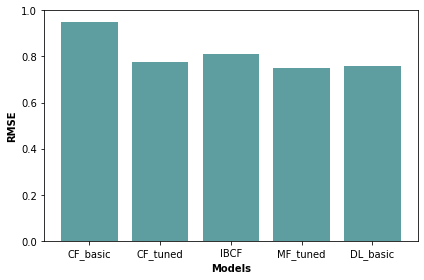

In [ ]:
import matplotlib.pyplot as plt 

labels = ['CF_basic', 'CF_tuned', 'IBCF', 'MF_tuned', 'DL_basic']

plt.bar([1, 2, 3, 4, 5], results, color='cadetblue')
plt.xticks([1, 2, 3, 4, 5], labels)
plt.xlabel('Models', fontweight='bold')
plt.ylabel('RMSE', fontweight='bold')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [ ]:
c_matrix_CF(CF_knn_bias_sig_cos, 90) 

20000
20000


,예측값(0),예측값(1)
실제값(0),1618,1431
실제값(1),2358,14593


In [ ]:
c_matrix_IBCF(CF_basic)

20000
20000


,예측값(0),예측값(1)
실제값(0),598,2451
실제값(1),1658,15293


In [ ]:
c_matrix_IBCF(CF_IBCF)

20000
20000


,예측값(0),예측값(1)
실제값(0),1691,1358
실제값(1),2707,14244


In [ ]:
c_matrix_MF(mf3)

20000
20000


,예측값(0),예측값(1)
실제값(0),1661,1388
실제값(1),2218,14733


In [ ]:
c_matrix_dl(model1)

In [ ]:
from sklearn.metrics import roc_curve

def get_fper_tper(model, model_type, neighbor_size=0):
  id_pairs = zip(datas[2][1]['m_no'], datas[2][1]['goodsno'])    # id_pairs: (user_id1, goodsno1), (user_id2, goodsno2), (user_id3, goodsno3) 쌍을 얻음 

  if neighbor_size == 0 and model_type == 'mf': 
    y_pred = np.array([model.get_one_prediction(user, item) for (user, item) in id_pairs])   # user_id와 movie_id 값을 이용해 예측 값 계산 
    y_pred = list(convert_sent(list(y_pred)))
    y_true = list(convert_sent(datas[2][1]['point']))   # test 데이터의 실제 값 저장 
    fper, tper, thresholds = roc_curve(y_true, y_pred)
    return fper, tper, thresholds 

  elif neighbor_size == 0 and model_type == 'dl':
    y_pred = np.array([model.predict([np.array([user, ]),np.array([item, ])]) + mu for (user, item) in id_pairs])   # user_id와 movie_id 값을 이용해 예측 값 계산 
    y_pred = list(convert_sent(list(y_pred)))
    y_true = list(convert_sent(datas[2][1]['point']))   # test 데이터의 실제 값 저장
    fper, tper, thresholds = roc_curve(y_true, y_pred)
    return fper, tper, thresholds

  elif neighbor_size == 0 and model_type == 'cf':
    id_pairs = zip(datas[2][1]['m_no'], datas[2][1]['goodsno'])    # id_pairs: (user_id1, goodsno1), (user_id2, goodsno2), (user_id3, goodsno3) 쌍을 얻음 
    y_pred = np.array([model(user, item) for (user, item) in id_pairs])   # user_id와 movie_id 값을 이용해 예측 값 계산 
    y_pred = list(convert_sent(list(y_pred)))
    y_true = list(convert_sent(datas[2][1]['point']))   # test 데이터의 실제 값 저장 
    fper, tper, thresholds = roc_curve(y_true, y_pred)
    return fper, tper, thresholds
    
  else:
    y_pred = np.array([model(user, item, neighbor_size) for (user, item) in id_pairs])   # user_id와 movie_id 값을 이용해 예측 값 계산 
    y_pred = list(convert_sent(list(y_pred)))
    y_true = list(convert_sent(datas[2][1]['point']))   # test 데이터의 실제 값 저장 
    fper, tper, thresholds = roc_curve(y_true, y_pred)
    return fper, tper, thresholds

In [ ]:
ft_list = []   # fpr tpr threshold list 

ft_list.append(get_fper_tper(CF_basic, 'cf'))
ft_list.append(get_fper_tper(CF_knn_bias_sig_cos,'cf', 90))
ft_list.append(get_fper_tper(CF_IBCF, 'cf'))
ft_list.append(get_fper_tper(mf3, 'mf'))
ft_list.append(get_fper_tper(model1, 'dl'))

In [ ]:
ft_list[0][0]

In [ ]:
import matplotlib.pyplot as plt 

f, ax = plt.subplots(2, 3, figsize=(16, 8))
idx = 0 

labels = ['CF_basic', 'CF_tuned', 'IBCF', 'MF_tuned', 'DL_basic']

for i in range(2):    
  for j in range(3):   
    try:
      # print([result[0] for result in ft_list[idx]], [result[1] for result in ft_list[idx]], )
      ax[i, j].plot(ft_list[idx][0], ft_list[idx][1], color='red', label='ROC')
      ax[i, j].plot([0, 1], [0, 1], color='green', linestyle = '--')
      # ax[i, j].plot([x for x in range(1, 101)], [result[3] for result in mf_ab_result[idx]], color='red', label='Test RMSE')
      # ax[i, j].set_ylim(0.5, 1.5)   # y축 범위 설정하기 
      ax[i, j].set_xlabel('False Positive Rate')   
      ax[i, j].set_ylabel('True Positive Rate')
      ax[i, j].legend()
      ax[i, j].set_title(f'{labels[idx]}', fontweight='bold')
      idx += 1
    except IndexError:
       ax[i, j].set_visible(False)

f.tight_layout()
plt.show()

In [ ]:
def c_matrix_MF(model, num_sample):
  n_items = datas[2][1].sample(num_sample)

  id_pairs = zip(n_items['m_no'], n_items['goodsno'])    # id_pairs: (user_id1, goodsno1), (user_id2, goodsno2), (user_id3, goodsno3) 쌍을 얻음 
  y_pred = np.array([model.get_one_prediction(user, item) for (user, item) in id_pairs])   # user_id와 movie_id 값을 이용해 예측 값 계산 
  # print(y_pred, type(y_pred))
  y_pred = list(convert_sent(list(y_pred)))
  y_true = list(convert_sent(n_items['point']))   # test 데이터의 실제 값 저장 
  
  cm = confusion_matrix(y_true, y_pred)
  cmdf = pd.DataFrame(cm, index=['실제값(0)', '실제값(1)'], columns=['예측값(0)', '예측값(1)'])
  return cmdf

In [ ]:
n_items = datas[2][1].sample(5, random_state=42)
n_items

In [ ]:
datas[2][1].sample(5, random_state=42)

In [ ]:
id_pairs = zip(list(zip(datas[2][1]['m_no'], datas[2][1]['goodsno']))[:5])
list(id_pairs)

In [ ]:
item_10 = c_matrix_MF(mf3, 10)
item_10

In [ ]:
item_20 = c_matrix_MF(mf3, 20)
item_20

In [ ]:
item_30 = c_matrix_MF(mf3, 30)
item_30

In [ ]:
item_40 = c_matrix_MF(mf3, 40)
item_40

In [ ]:
item_50 = c_matrix_MF(mf3, 50)
item_50

In [ ]:
def get_acc(matrix):
  tp = matrix['예측값(0)'][0] # TP 
  fn = matrix['예측값(0)'][1] # FN
  fp = matrix['예측값(1)'][0] # FP
  tn = matrix['예측값(1)'][1] # TN

  acc = (tp + tn) / (tp + tn + fp + tn)
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  tpr = tp / (tp + fn)
  fpr = fp / (fp + tn)

  return acc, precision, recall, fpr 

In [ ]:
get_acc(item_10)

In [ ]:
get_acc(item_20)

In [ ]:
get_acc(item_30)

In [ ]:
get_acc(item_40)

In [ ]:
get_acc(item_50)

In [ ]:
from sklearn.metrics import precision_recall_curve

id_pairs = zip(datas[2][1]['m_no'], datas[2][1]['goodsno'])
y_pred = np.array([mf3.get_one_prediction(user, item) for (user, item) in id_pairs])   # user_id와 movie_id 값을 이용해 예측 값 계산 
y_pred = list(convert_sent(list(y_pred)))
y_true = list(convert_sent(datas[2][1]['point']))   # test 데이터의 실제 값 저장 

pr_logistic,rc_logistic, pr_rc_thre_logistic = precision_recall_curve(y_true=y_true, probas_pred=y_pred)

In [ ]:
datas[2][1]['point'].mean()

In [ ]:
# Precision-Recall Curve 그리기
# plt.subplot(122)
plt.plot(rc_logistic, pr_logistic, color='red')
# base_rate = datas[2][1]['point'].mean()
# plt.plot([0,1],[base_rate,base_rate],'k--')

# styling figure
plt.title('Precision \ Recall Cureve',fontsize=16,fontweight="bold",y=1)
plt.xlabel('Recall',fontsize=14,labelpad=10)
plt.ylabel('Precision',fontsize=14,labelpad=10,)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(-0.01,1.01)
# plt.ylim(base_rate-0.05,1.01)

plt.tight_layout()